<Figure size 1200x600 with 0 Axes>

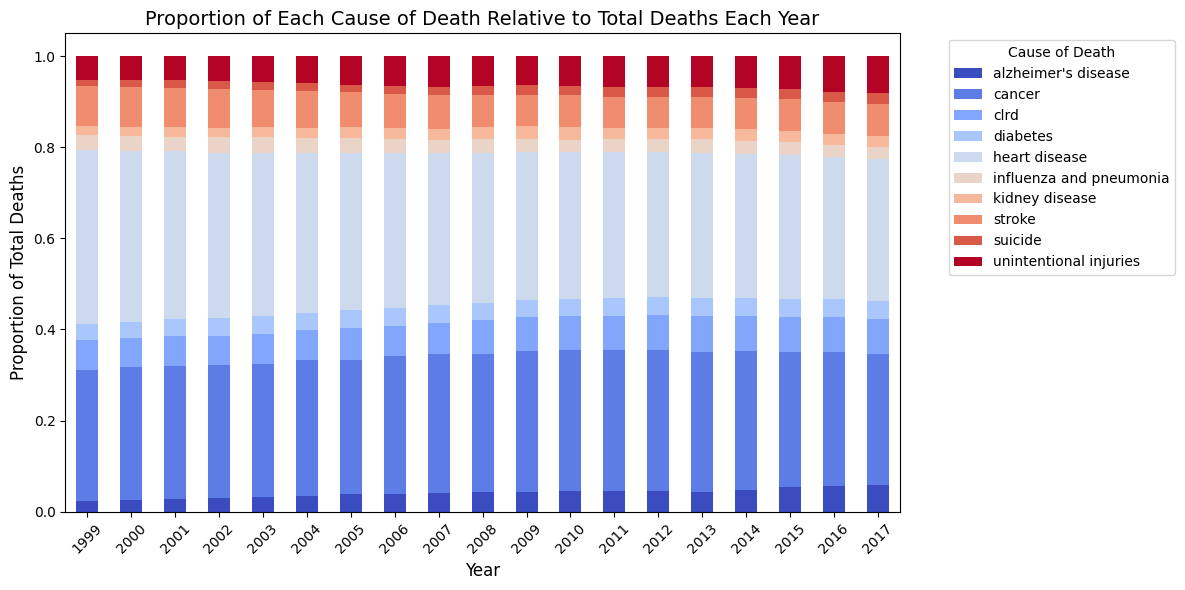

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
# import ace_tools as tools  # For displaying the dataframe

# Load dataset
df = pd.read_csv('../data/processed/US_Deaths_Populations.csv', sep=',')
df_filtered = df[df["State"] != "United States"]

# Aggregate total deaths for each year (across all causes)
total_deaths_per_year = df_filtered.groupby("Year")["Deaths"].sum()

# Aggregate deaths by cause and year
cause_death_per_year = df_filtered.groupby(["Year", "Cause Name"])["Deaths"].sum().unstack()

# Calculate proportion (divide each cause by total deaths in that year)
cause_death_proportion = cause_death_per_year.div(total_deaths_per_year, axis=0)

plt.figure(figsize=(12, 6))
cause_death_proportion.plot(kind="bar", stacked=True, figsize=(12, 6), colormap="coolwarm")

# Customize plot
plt.title("Proportion of Each Cause of Death Relative to Total Deaths Each Year", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Proportion of Total Deaths", fontsize=12)
plt.legend(title="Cause of Death", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xticks(rotation=45)

# Show plot
plt.tight_layout()
plt.show()


Index(['alzheimer's disease', 'cancer', 'clrd', 'diabetes', 'heart disease',
       'influenza and pneumonia', 'kidney disease', 'stroke', 'suicide',
       'unintentional injuries'],
      dtype='object', name='Cause Name')
Heart Disease Trend (slope): -0.0038678746990787453
Cancer Trend (slope): 0.0005728046472224311


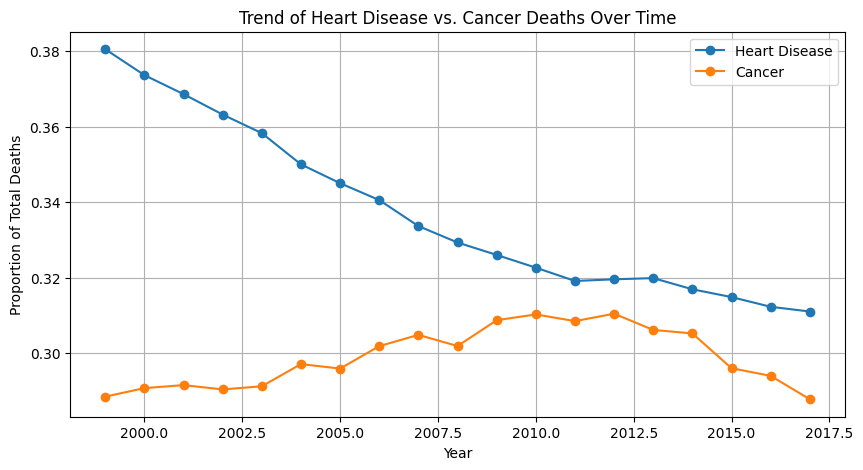

In [5]:
# From the graph I can see heart disease is decreasing while cancer is increasing
# Confirm the trend
from scipy.stats import linregress

print(cause_death_proportion.columns)

years = cause_death_proportion.index.astype(int)
heart_disease_trend = linregress(years, cause_death_proportion["heart disease"])
cancer_trend = linregress(years, cause_death_proportion["cancer"])

print("Heart Disease Trend (slope):", heart_disease_trend.slope)
print("Cancer Trend (slope):", cancer_trend.slope)

plt.figure(figsize=(10, 5))
plt.plot(cause_death_proportion.index, cause_death_proportion["heart disease"], marker='o', label="Heart Disease")
plt.plot(cause_death_proportion.index, cause_death_proportion["cancer"], marker='o', label="Cancer")

plt.title("Trend of Heart Disease vs. Cancer Deaths Over Time")
plt.xlabel("Year")
plt.ylabel("Proportion of Total Deaths")
plt.legend()
plt.grid(True)
plt.show()

In [6]:
# TODO: identify which state contributes to positive trend in cancer

<Figure size 1400x800 with 0 Axes>

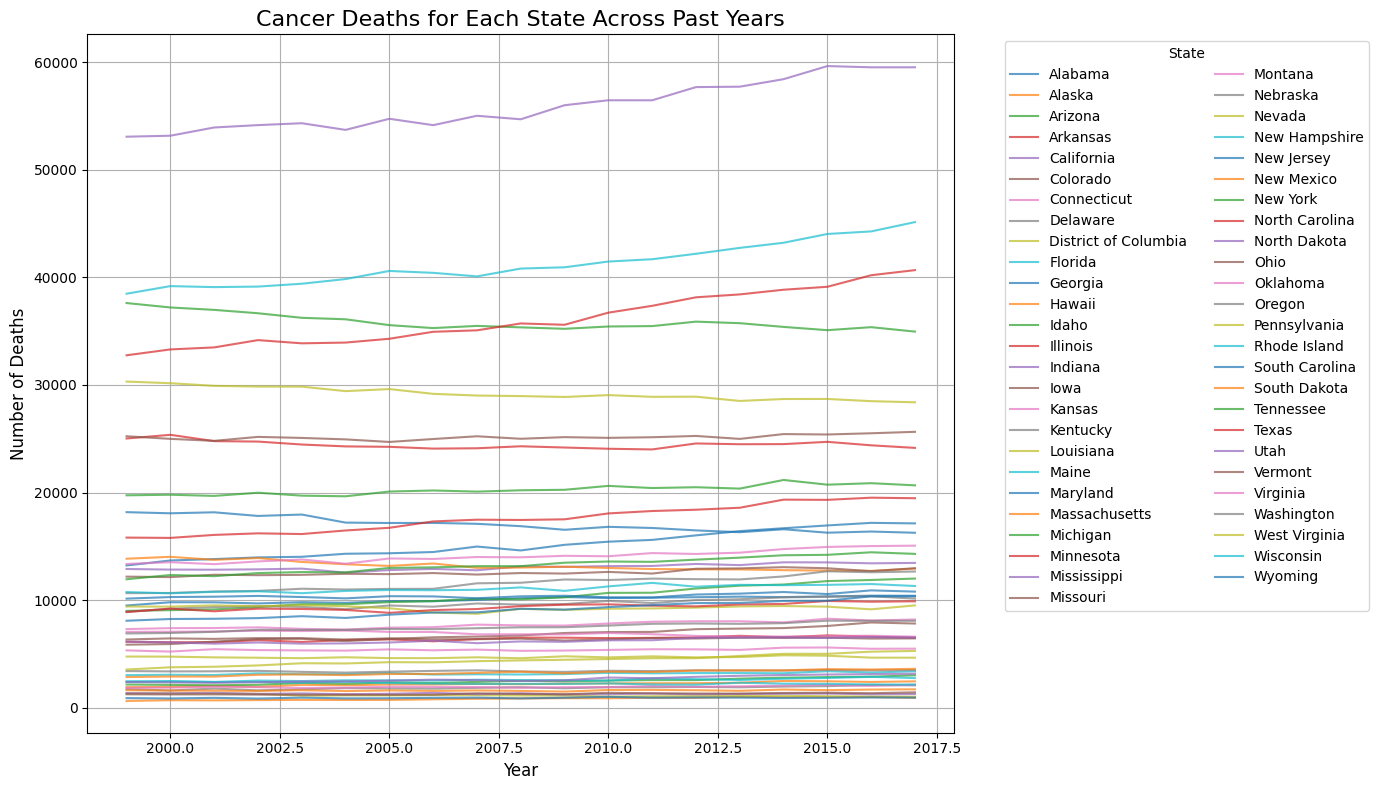

Top 5 States with Largest Increase in Cancer Deaths:
State
Texas             7913
Florida           6653
California        6449
Georgia           3910
North Carolina    3659
dtype: int64

Top 5 States with Largest Decrease in Cancer Deaths:
State
New York        -2653
Pennsylvania    -1925
New Jersey      -1914
Massachusetts    -919
Illinois         -874
dtype: int64


In [8]:
# Filter data for cancer deaths across all states and years
cancer_data = df_filtered[df_filtered["Cause Name"] == "cancer"]

# Group data by state and year, summing the deaths for each combination
state_year_cancer_deaths = cancer_data.groupby(["State", "Year"])["Deaths"].sum().unstack()

# Plot cancer deaths for each state over the years
plt.figure(figsize=(14, 8))
state_year_cancer_deaths.T.plot(figsize=(14, 8), legend=False, alpha=0.7)

# Add labels and title
plt.title("Cancer Deaths for Each State Across Past Years", fontsize=16)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Number of Deaths", fontsize=12)
plt.grid(True)

# Adjust legend to show state names
plt.legend(title="State", bbox_to_anchor=(1.05, 1), loc="upper left", ncol=2, fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()

# Calculate the change (last year - first year) for each state
state_cancer_changes = state_year_cancer_deaths.iloc[:, -1] - state_year_cancer_deaths.iloc[:, 0]

# Sort states by largest increase
largest_increase = state_cancer_changes.sort_values(ascending=False)

# Sort states by largest decrease
largest_decrease = state_cancer_changes.sort_values()

# Display results
print("Top 5 States with Largest Increase in Cancer Deaths:")
print(largest_increase.head())

print("\nTop 5 States with Largest Decrease in Cancer Deaths:")
print(largest_decrease.head())



In [9]:
# Calculate cancer deaths per 100,000 people
population_data = df_filtered.groupby(["State", "Year"])["Population"].mean().unstack()
state_year_cancer_death_rates = state_year_cancer_deaths / population_data * 100000

# Compute changes in age-adjusted rates
state_cancer_rate_changes = state_year_cancer_death_rates.iloc[:, -1] - state_year_cancer_death_rates.iloc[:, 0]

# Sort and display
largest_increase_rates = state_cancer_rate_changes.sort_values(ascending=False)
largest_decrease_rates = state_cancer_rate_changes.sort_values()

print("Top 5 States with Largest Increase in Cancer Death Rates:")
print(largest_increase_rates.head())

print("\nTop 5 States with Largest Decrease in Cancer Death Rates:")
print(largest_decrease_rates.head())


Top 5 States with Largest Increase in Cancer Death Rates:
State
Alaska        23.853985
Vermont       22.387318
New Mexico    15.353090
Maine         14.256504
Hawaii        13.736599
dtype: float64

Top 5 States with Largest Decrease in Cancer Death Rates:
State
District of Columbia   -86.434832
North Dakota           -42.578309
New Jersey             -36.852948
Rhode Island           -33.458639
Massachusetts          -30.737910
dtype: float64


                          Population Change (%)  Cancer Death Rate Change
Population Change (%)                  1.000000                 -0.006431
Cancer Death Rate Change              -0.006431                  1.000000


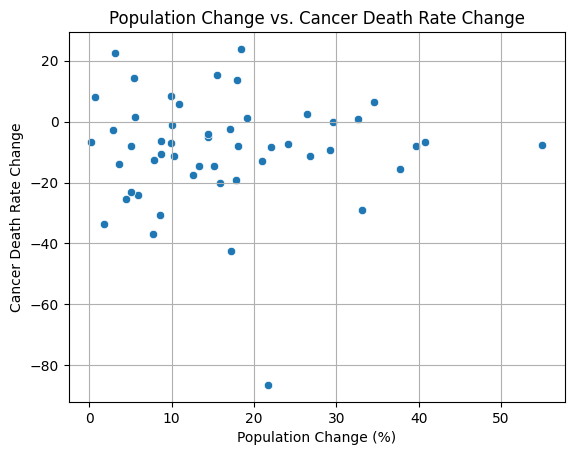

In [10]:
# Calculate population change between first and last year
state_population_change = (population_data.iloc[:, -1] - population_data.iloc[:, 0]) / population_data.iloc[:, 0] * 100

# Compare population change with cancer death rate change
comparison_df = pd.DataFrame({
    "Population Change (%)": state_population_change,
    "Cancer Death Rate Change": state_cancer_rate_changes
})

# Check correlation
print(comparison_df.corr())

# Scatter plot
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(x=comparison_df["Population Change (%)"], y=comparison_df["Cancer Death Rate Change"])
plt.title("Population Change vs. Cancer Death Rate Change")
plt.xlabel("Population Change (%)")
plt.ylabel("Cancer Death Rate Change")
plt.grid(True)
plt.show()


# There is virtually no relationship between the two variables.
# Prophet is a time series forecasting model, meaning it learns from historical patterns in cancer deaths over time.

21:24:38 - cmdstanpy - INFO - Chain [1] start processing
21:24:38 - cmdstanpy - INFO - Chain [1] done processing


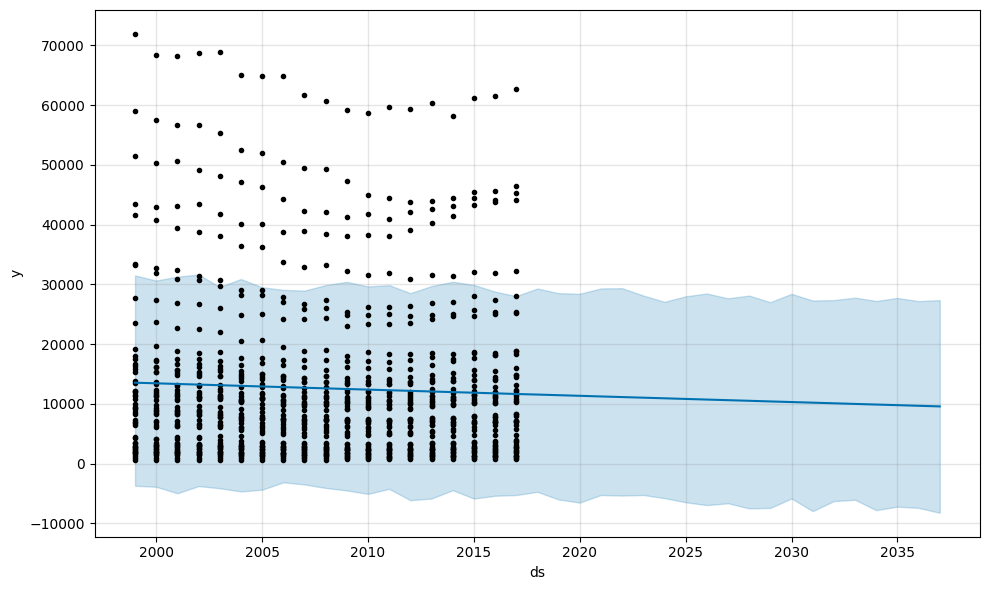

21:24:38 - cmdstanpy - INFO - Chain [1] start processing
21:24:38 - cmdstanpy - INFO - Chain [1] done processing


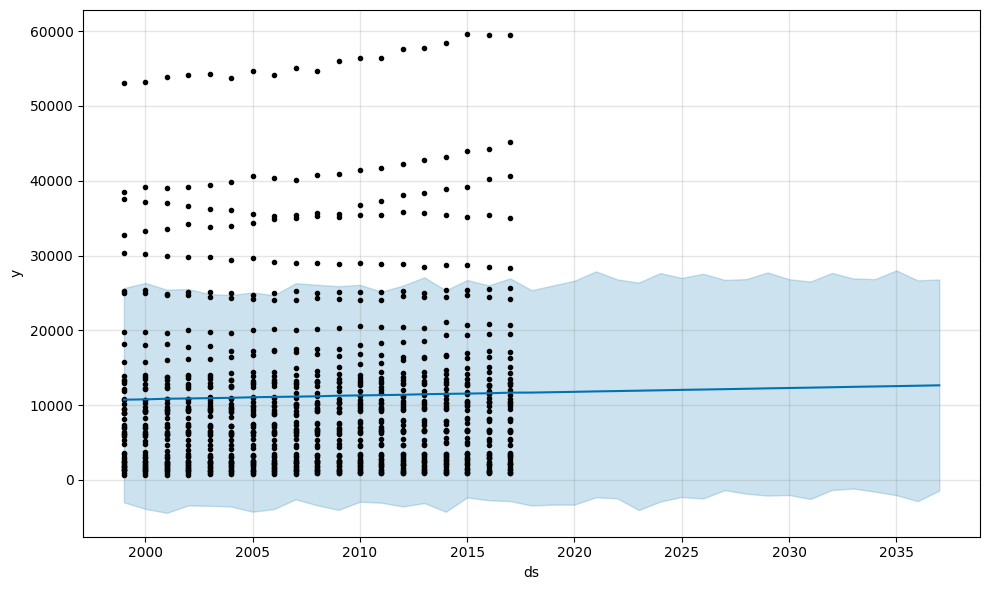

In [12]:
# Predict for Heart disease
df_heart_disease = df_filtered[df_filtered["Cause Name"] == "heart disease"][["Year", "Deaths"]].rename(columns={"Year": "ds", "Deaths": "y"})
df_heart_disease["ds"] = pd.to_datetime(df_heart_disease["ds"], format="%Y") # format x-axis label

# Train model
model = Prophet()
model.fit(df_heart_disease)

# Predict future years
future = model.make_future_dataframe(periods=20, freq="YE")
forecast = model.predict(future)

# Plot forecast
model.plot(forecast)
plt.show()

# Predict for cancer
df_cancer = df_filtered[df_filtered["Cause Name"] == "cancer"][["Year", "Deaths"]].rename(columns={"Year": "ds", "Deaths": "y"})
df_cancer["ds"] = pd.to_datetime(df_cancer["ds"], format="%Y") # format x-axis label

# Train model
model = Prophet()
model.fit(df_cancer)

# Predict future years
future = model.make_future_dataframe(periods=20, freq="YE")
forecast = model.predict(future)

# Plot forecast
model.plot(forecast)
plt.show()
